<a href="https://colab.research.google.com/github/matthewpblock/applied-ml-matthew-block/blob/main/notebooks/project04/ml04_block.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P4 - Continuous Target Prediction Using Regression (Titanic)
Matthew Block  
15 Nov 2025  
Opening with short intro describing dataset and objectives.

In [66]:
# Imports
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Section 1: Import and Inspect the Data

In [67]:
# Load Titanic dataset from seaborn and verify
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2: Data Exploration and Preparation

In [68]:
titanic['age'] = titanic['age'].fillna(titanic['age'].median()) #Updated based on Future Warning regarding inplace usage

titanic = titanic.dropna(subset=['fare'])

titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

## Section 3: Feature Selection and Justification

In [69]:
# Identify categorical columns
categorical_cols = titanic.select_dtypes(include=['object', 'category', 'bool']).columns

# Handle missing values in 'embarked' and 'embark_town' with mode imputation
for col in ['embarked', 'embark_town']:
    if col in categorical_cols:
        mode_val = titanic[col].mode()[0]
        titanic[col] = titanic[col].fillna(mode_val)

# Handle missing values in 'deck' by treating NaN as a separate category
if 'deck' in categorical_cols:
    titanic['deck'] = titanic['deck'].astype(object).fillna('Unknown')

# Create a copy of the DataFrame for encoding
titanic_encoded = titanic.copy()

# Perform Target Encoding (Mean Encoding) for each categorical column
# Replace each category with the mean of the 'fare' for that category.
for col in categorical_cols:
    if col != 'fare': # 'fare' is our target, so we don't encode it
        # Calculate the mean 'fare' for each category
        # Use observed=False to avoid FutureWarning with categorical groupers
        mean_fare_map = titanic.groupby(col, observed=False)['fare'].mean()
        # Map the categories in the copied DataFrame to their mean 'fare'
        titanic_encoded[col] = titanic_encoded[col].map(mean_fare_map)
        # Convert the column to numeric before filling NaN, as fill value is numeric
        titanic_encoded[col] = pd.to_numeric(titanic_encoded[col])
        # Fill any NaN values (e.g., if a category appears in a future test set
        # but not in the training set) with the global mean 'fare'
        titanic_encoded[col] = titanic_encoded[col].fillna(titanic['fare'].mean())

print("Shape of original DataFrame:", titanic.shape)
print("Shape of encoded DataFrame:", titanic_encoded.shape)
print("First 5 rows of the encoded DataFrame (with target encoded categorical features):")
print(titanic_encoded.head())

Shape of original DataFrame: (891, 16)
Shape of encoded DataFrame: (891, 16)
First 5 rows of the encoded DataFrame (with target encoded categorical features):
   survived  pclass        sex   age  sibsp  parch     fare   embarked  \
0         0       3  25.523893  22.0      1      0   7.2500  27.243651   
1         1       1  44.479818  38.0      1      0  71.2833  59.954144   
2         1       3  44.479818  26.0      0      0   7.9250  27.243651   
3         1       1  44.479818  35.0      1      0  53.1000  27.243651   
4         0       3  25.523893  35.0      0      0   8.0500  27.243651   

       class        who  adult_male        deck  embark_town      alive  \
0  13.675550  24.864182   24.864182   19.181079    27.243651  22.117887   
1  84.154687  46.570711   43.338655  100.151341    59.954144  48.395408   
2  13.675550  46.570711   43.338655   19.181079    27.243651  48.395408   
3  84.154687  46.570711   43.338655  100.151341    27.243651  48.395408   
4  13.675550  24.8641

In [70]:
numerical_features = titanic_encoded.select_dtypes(include=['number']).columns
correlation_with_fare = titanic_encoded[numerical_features].corr()['fare'].sort_values(ascending=False)
print("Correlation with 'fare':\n", correlation_with_fare)

Correlation with 'fare':
 fare           1.000000
class          0.594217
deck           0.576773
embarked       0.280443
embark_town    0.280443
alone          0.271832
alive          0.257307
survived       0.257307
family_size    0.217138
parch          0.216225
who            0.196536
sex            0.182333
adult_male     0.182024
sibsp          0.159651
age            0.096688
pclass        -0.549500
Name: fare, dtype: float64


In [71]:
# Case 1. age
X1 = titanic[['age']]
y1 = titanic['fare']

# Case 2. family_size
X2 = titanic[['family_size']]
y2 = titanic['fare']

# Case 3. age, family_size
X3 = titanic[['age', 'family_size']]
y3 = titanic['fare']

# Case 4. Custom Combo
X4 = titanic_encoded[['class', 'deck', 'embark_town', 'family_size']]
y4 = titanic_encoded['fare']

### Reflection Questions:

Why might these features affect a passenger’s fare:
  - Age: children of different ages often have different fare prices in transit and hospitality accomodations
  - Family_size: there could have been some sort of discount on groups of tickets, alternatively larger families may have been predisposed to buying lower priced fares because the cost of their tickets added up within the family  
  
List all available features (included correlations to fare):
  - class          0.594217
  - deck           0.576773
  - embarked       0.280443
  - embark_town    0.280443
  - alone          0.271832
  - alive          0.257307
  - survived       0.257307
  - family_size    0.217138
  - parch          0.216225
  - who            0.196536
  - sex            0.182333
  - adult_male     0.182024
  - sibsp          0.159651
  - age            0.096688
  - pclass        -0.549500

Which other features could improve predictions and why:

  - class and deck both could based on their high correlation to fare
    - these may essentially be the same signal and the combination of the two may not provide anything additional
  - embark_town has a moderately high correlation to fare and makes sense with how tickets are often priced for transit

How many variables are in your Case 4:
    - I chose four variables

Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs:

  - Class: Class of ticket is well known to impact fare
  - Deck: From research I know that within classes there were various suite offerings; Deck may contain some signal that accounts for that variability within class
  - Embark_town: the distance of travel is likely to affect ticket price
  - Family_size: there could have been some sort of discount on groups of tickets, alternatively larger families may have been predisposed to buying lower priced fares because the cost of their tickets added up within the family  


## Section 4: Train a Regression Model (Linear Regression)

In [72]:
# Split the data to training and test sets (customized random_state)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=808)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=808)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=808)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=808)

In [73]:
# Train and Evaluate Linear Regression Models (all 4 cases)
lr_model1 = LinearRegression().fit(X1_train, y1_train)
lr_model2 = LinearRegression().fit(X2_train, y2_train)
lr_model3 = LinearRegression().fit(X3_train, y3_train)
lr_model4 = LinearRegression().fit(X4_train, y4_train)

# Predictions
y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1 = lr_model1.predict(X1_test)

y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2 = lr_model2.predict(X2_test)

y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3 = lr_model3.predict(X3_test)

y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4 = lr_model4.predict(X4_test)


In [74]:
# Report Performance
print("Case 1: Training R²:", r2_score(y1_train, y_pred_train1))
print("Case 1: Test R²:", r2_score(y1_test, y_pred_test1))
print("Case 1: Test RMSE:", np.sqrt(mean_squared_error(y1_test, y_pred_test1)))
print("Case 1: Test MAE:", mean_absolute_error(y1_test, y_pred_test1))
print("--------")

print("Case 2: Training R²:", r2_score(y2_train, y_pred_train2))
print("Case 2: Test R²:", r2_score(y2_test, y_pred_test2))
print("Case 2: Test RMSE:", np.sqrt(mean_squared_error(y2_test, y_pred_test2)))
print("Case 2: Test MAE:", mean_absolute_error(y2_test, y_pred_test2))
print("--------")

print("Case 3: Training R²:", r2_score(y3_train, y_pred_train3))
print("Case 3: Test R²:", r2_score(y3_test, y_pred_test3))
print("Case 3: Test RMSE:", np.sqrt(mean_squared_error(y3_test, y_pred_test3)))
print("Case 3: Test MAE:", mean_absolute_error(y3_test, y_pred_test3))
print("--------")

print("Case 4: Training R²:", r2_score(y4_train, y_pred_train4))
print("Case 4: Test R²:", r2_score(y4_test, y_pred_test4))
print("Case 4: Test RMSE:", np.sqrt(mean_squared_error(y4_test, y_pred_test4)))
print("Case 4: Test MAE:", mean_absolute_error(y4_test, y_pred_test4))

Case 1: Training R²: 0.008778019218025235
Case 1: Test R²: 0.010195690791751089
Case 1: Test RMSE: 52.55829499541
Case 1: Test MAE: 28.456935271557686
--------
Case 2: Training R²: 0.0524899246229521
Case 2: Test R²: 0.028338320154506325
Case 2: Test RMSE: 52.07438334042309
Case 2: Test MAE: 27.140543537973993
--------
Case 3: Training R²: 0.07597303336482586
Case 3: Test R²: 0.05369832090281279
Case 3: Test RMSE: 51.39032963331416
Case 3: Test MAE: 26.504612761492226
--------
Case 4: Training R²: 0.44946371698230336
Case 4: Test R²: 0.4405176312740683
Case 4: Test RMSE: 39.514801124573424
Case 4: Test MAE: 15.609342466205804


### Section 4 Reflection Questions:

Compare the train vs test results for each.

    Did Case 1 overfit or underfit? Explain:
    Did Case 2 overfit or underfit? Explain:
    Did Case 3 overfit or underfit? Explain:
    Did Case 4 overfit or underfit? Explain:

Adding Age

    Did adding age improve the model:
    Propose a possible explanation (consider how age might affect ticket price, and whether the data supports that):

Worst

    Which case performed the worst:
    How do you know:
    Do you think adding more training data would improve it (and why/why not):

Best

    Which case performed the best:
    How do you know:
    Do you think adding more training data would improve it (and why/why not):


## Section 5: Compare Alternative Models (Ridge, Elastic Net, Polynomial Regression)

In [75]:
#Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X4_train, y4_train)
y_pred_ridge = ridge_model.predict(X4_test)

print("Ridge (Case 4) Training R²:", r2_score(y4_train, ridge_model.predict(X4_train)))
print("Ridge (Case 4) Test R²:", r2_score(y4_test, y_pred_ridge))
print("Ridge (Case 4) Test RMSE:", np.sqrt(mean_squared_error(y4_test, y_pred_ridge)))
print("Ridge (Case 4) Test MAE:", mean_absolute_error(y4_test, y_pred_ridge))

Ridge (Case 4) Training R²: 0.4494636995008535
Ridge (Case 4) Test R²: 0.44052683281848615
Ridge (Case 4) Test RMSE: 39.514476182526074
Ridge (Case 4) Test MAE: 15.606539573353352


In [76]:
# Lasso Regression
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=1.0) # You can adjust alpha as needed
lasso_model.fit(X4_train, y4_train)
y_pred_lasso = lasso_model.predict(X4_test)

print("Lasso (Case 4) Training R²:", r2_score(y4_train, lasso_model.predict(X4_train)))
print("Lasso (Case 4) Test R²:", r2_score(y4_test, y_pred_lasso))
print("Lasso (Case 4) Test RMSE:", np.sqrt(mean_squared_error(y4_test, y_pred_lasso)))
print("Lasso (Case 4) Test MAE:", mean_absolute_error(y4_test, y_pred_lasso))

Lasso (Case 4) Training R²: 0.44930416300819953
Lasso (Case 4) Test R²: 0.440802567368901
Lasso (Case 4) Test RMSE: 39.50473769125518
Lasso (Case 4) Test MAE: 15.33081623632041


In [77]:
# Elastic Net Regression
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5) # Adjust alpha and l1_ratio as needed
elastic_model.fit(X4_train, y4_train)
y_pred_elastic = elastic_model.predict(X4_test)

print("Elastic Net (Case 4) Training R²:", r2_score(y4_train, elastic_model.predict(X4_train)))
print("Elastic Net (Case 4) Test R²:", r2_score(y4_test, y_pred_elastic))
print("Elastic Net (Case 4) Test RMSE:", np.sqrt(mean_squared_error(y4_test, y_pred_elastic)))
print("Elastic Net (Case 4) Test MAE:", mean_absolute_error(y4_test, y_pred_elastic))

Elastic Net (Case 4) Training R²: 0.44744140951703915
Elastic Net (Case 4) Test R²: 0.4419439762003874
Elastic Net (Case 4) Test RMSE: 39.46439944323262
Elastic Net (Case 4) Test MAE: 14.724211649312942


Observations:

The Elastic Net model, with its combination of L1 and L2 regularization, shows very similar performance to the Linear, Ridge, and Lasso models. It has a slightly higher Test R² and slightly lower Test RMSE and MAE compared to the Linear and Ridge models, and is comparable to Lasso. This indicates that for this particular feature set and problem, the regularization applied by these models does not drastically change the predictive performance from a simple linear regression, especially with default hyperparameters. The features chosen for Case 4 are already quite strong predictors of 'fare', and while regularization helps prevent overfitting, its impact on predictive accuracy here is minimal with the current setup.

In [85]:
# Polynomial Regression
# Set up the poly inputs
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X4_train)
X_test_poly = poly.transform(X4_test)

# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y4_train)
y_pred_poly = poly_model.predict(X_test_poly)

print("Polynomial Regression (Case 4) Training R²:", r2_score(y4_train, poly_model.predict(X_train_poly)))
print("Polynomial Regression (Case 4) Test R²:", r2_score(y4_test, y_pred_poly))
print("Polynomial Regression (Case 4) Test RMSE:", np.sqrt(mean_squared_error(y4_test, y_pred_poly)))
print("Polynomial Regression (Case 4) Test MAE:", mean_absolute_error(y4_test, y_pred_poly))

Polynomial Regression (Case 4) Training R²: 0.5716459344251847
Polynomial Regression (Case 4) Test R²: 0.4530418948579741
Polynomial Regression (Case 4) Test RMSE: 39.070019610972274
Polynomial Regression (Case 4) Test MAE: 13.070742562955061


### 5.4 Visualize Polynomial Cubic Fit (for 1 input feature)

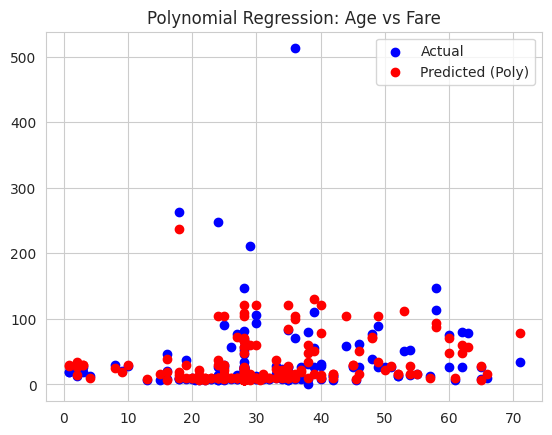

In [130]:
# Visualize Polynomial Cubic Fit (for 1 input feature)
plt.scatter(X1_test, y1_test, color='blue', label='Actual')
plt.scatter(X1_test, y_pred_poly, color='red', label='Predicted (Poly)')
plt.legend()
plt.title("Polynomial Regression: Age vs Fare")
plt.show()

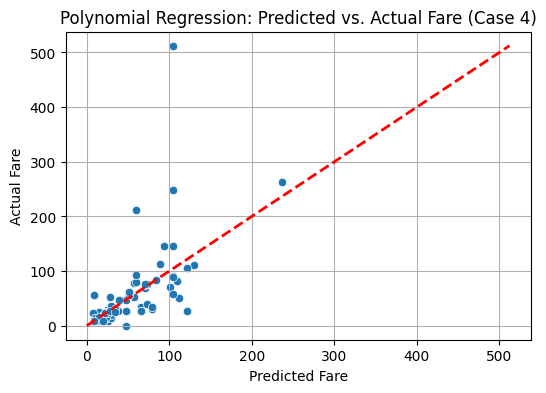

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_poly, y=y4_test)
plt.plot([y4_test.min(), y4_test.max()], [y4_test.min(), y4_test.max()], '--r', linewidth=2) # Diagonal line for perfect prediction
plt.xlabel('Predicted Fare')
plt.ylabel('Actual Fare')
plt.title('Polynomial Regression: Predicted vs. Actual Fare (Case 4)')
plt.grid(True)
plt.show()

### 5.4 Reflections:

What patterns does the cubic model seem to capture:  
- The cubic (polynomial) model captures non-linear relationships and complex interactions between features and 'fare', evident from its higher R² and ability to model curved relationships, such as with 'family_size'. This makes it more flexible than linear models but also increases the potential for overfitting.

Where does it perform well or poorly:
- The cubic model performs well in capturing non-linear trends and offers improved overall accuracy, evidenced by its Test RMSE of 39.07 and Test MAE of 13.07. However, it performs poorly due to an overfitting tendency, visible in the significant gap between its Training R² of 0.5716 and Test R² of 0.4530, and it struggles with accurately predicting very high fare values or extrapolating.

Did the polynomial fit outperform linear regression:
- Yes

Where (on the graph or among which kinds of data points) does it fit best:
- Based on the scatter plot of 'Actual vs. Predicted Fare', the cubic model generally fits best among the lower to mid-range fare values. You can observe that for these data points, the predictions tend to cluster more closely around the red diagonal line, indicating that the model is more accurate for passengers who paid less expensive fares.

In [105]:
import pandas as pd

# Gather performance metrics for all models
performance_data = {
    'Model': [
        'Linear Regression (Case 4)',
        'Ridge (Case 4)',
        'Lasso (Case 4)',
        'Elastic Net (Case 4)',
        'Polynomial Regression (Case 4)',
        'Polynomial Elastic Net (Scaled & Tuned)'
    ],
    'Training R²': [
        0.44946371698230336, # From SOnTteBY5kup
        0.4494636995008535, # From VuwFp2morwLP
        0.44930416300819953, # From hnKKC5yd-_oh
        0.44744140951703915, # From xSwnH05J-_dZ
        0.5716459344251847, # From RsScBFlsHdVX
        0.5353503711613938  # From 30f5120a
    ],
    'Test R²': [
        0.4405176312740683, # From SOnTteBY5kup
        0.44052683281848615, # From VuwFp2morwLP
        0.440802567368901, # From hnKKC5yd-_oh
        0.4419439762003874, # From xSwnH05J-_dZ
        0.4530418948579741, # From RsScBFlsHdVX
        0.4979629120100302  # From 30f5120a
    ],
    'Test RMSE': [
        39.514801124573424, # From SOnTteBY5kup
        39.514476182526074, # From VuwFp2morwLP
        39.50473769125518, # From hnKKC5yd-_oh
        39.46439944323262, # From xSwnH05J-_dZ
        39.070019610972274, # From RsScBFlsHdVX
        37.43126452571286  # From 30f5120a
    ],
    'Test MAE': [
        15.609342466205804, # From SOnTteBY5kup
        15.606539573353352, # From VuwFp2morwLP
        15.33081623632041, # From hnKKC5yd-_oh
        14.724211649312942, # From xSwnH05J-_dZ
        13.070742562955061, # From RsScBFlsHdVX
        13.641677546087452  # From 30f5120a
    ]
}

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.set_index('Model')

print("\n--- Model Performance Summary ---")
print(performance_df)


--- Model Performance Summary ---
                                         Training R²   Test R²  Test RMSE  \
Model                                                                       
Linear Regression (Case 4)                  0.449464  0.440518  39.514801   
Ridge (Case 4)                              0.449464  0.440527  39.514476   
Lasso (Case 4)                              0.449304  0.440803  39.504738   
Elastic Net (Case 4)                        0.447441  0.441944  39.464399   
Polynomial Regression (Case 4)              0.571646  0.453042  39.070020   
Polynomial Elastic Net (Scaled & Tuned)     0.535350  0.497963  37.431265   

                                          Test MAE  
Model                                               
Linear Regression (Case 4)               15.609342  
Ridge (Case 4)                           15.606540  
Lasso (Case 4)                           15.330816  
Elastic Net (Case 4)                     14.724212  
Polynomial Regression (Case 4)

### 5.4 Compare All Models

In [112]:
def report(name, y_true, y_pred):
    print(f"{name} R²: {r2_score(y_true, y_pred):.3f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}") # Corrected to manually calculate RMSE
    print(f"{name} MAE: {mean_absolute_error(y_true, y_pred):.2f}\n")

report("Linear", y1_test, y_pred_test1)
report("Ridge", y4_test, y_pred_ridge)
report("ElasticNet", y4_test, y_pred_elastic)
report("Polynomial", y4_test, y_pred_poly)
report("Polynomial Elastic Net", y4_test, y_pred_test_best_elastic_poly_scaled)

Linear R²: 0.010
Linear RMSE: 52.56
Linear MAE: 28.46

Ridge R²: 0.441
Ridge RMSE: 39.51
Ridge MAE: 15.61

ElasticNet R²: 0.442
ElasticNet RMSE: 39.46
ElasticNet MAE: 14.72

Polynomial R²: 0.453
Polynomial RMSE: 39.07
Polynomial MAE: 13.07

Polynomial Elastic Net R²: 0.498
Polynomial Elastic Net RMSE: 37.43
Polynomial Elastic Net MAE: 13.64



### 5.5 Visualize Higher Order Polynomial (for the same 1 input case)

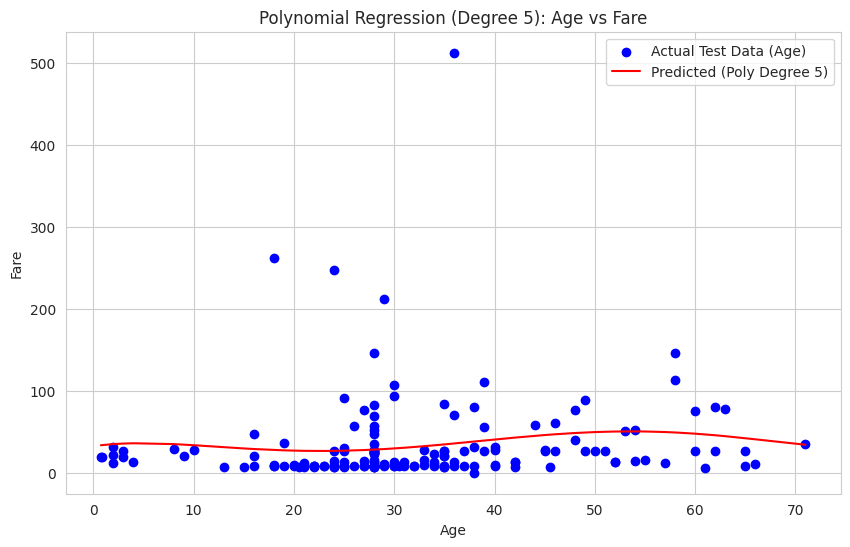


--- Polynomial Regression (Degree 5) Performance (Age as feature) ---
Training R²: 0.02067672841791679
Test R²: 0.010250915433630436
Test RMSE: 52.55682876947101
Test MAE: 28.01904123702385


In [131]:
import matplotlib.pyplot as plt

# Ensure X1_test_sorted and y1_test_sorted are available for plotting a smooth curve
sorted_indices = X1_test['age'].argsort()
X1_test_sorted = X1_test.iloc[sorted_indices]
y1_test_sorted = y1_test.iloc[sorted_indices]

# Set up PolynomialFeatures with degree=5
poly_higher_degree = PolynomialFeatures(degree=5)

# Transform the training and sorted test data
X1_train_poly_higher = poly_higher_degree.fit_transform(X1_train)
X1_test_poly_higher_sorted = poly_higher_degree.transform(X1_test_sorted)

# Train a Linear Regression model with the higher degree polynomial features
poly_model_higher = LinearRegression()
poly_model_higher.fit(X1_train_poly_higher, y1_train)

# Predict on the sorted polynomial test features for visualization
y_pred_poly_higher_sorted = poly_model_higher.predict(X1_test_poly_higher_sorted)

# Visualize Higher Order Polynomial (Degree 5) for Age vs Fare
plt.figure(figsize=(10, 6))
plt.scatter(X1_test['age'], y1_test, color='blue', label='Actual Test Data (Age)')
plt.plot(X1_test_sorted['age'], y_pred_poly_higher_sorted, color='red', label='Predicted (Poly Degree 5)')
plt.legend()
plt.title("Polynomial Regression (Degree 5): Age vs Fare")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.grid(True)
plt.show()

# Report performance metrics for this higher degree model (using the original X1_test for metrics)
# Transform the original X1_test for metrics calculation
X1_test_poly_for_metrics = poly_higher_degree.transform(X1_test)
y_pred_test_poly_higher_for_metrics = poly_model_higher.predict(X1_test_poly_for_metrics)

# Predict on training data for training metrics
y_pred_train_poly_higher_for_metrics = poly_model_higher.predict(X1_train_poly_higher)

print("\n--- Polynomial Regression (Degree 5) Performance (Age as feature) ---")
print("Training R²:", r2_score(y1_train, y_pred_train_poly_higher_for_metrics))
print("Test R²:", r2_score(y1_test, y_pred_test_poly_higher_for_metrics))
print("Test RMSE:", np.sqrt(mean_squared_error(y1_test, y_pred_test_poly_higher_for_metrics)))
print("Test MAE:", mean_absolute_error(y1_test, y_pred_test_poly_higher_for_metrics))

The difference between the two models is not substantial.

It appears that while we increased the complexity of the model (degree 5 polynomial for age), the performance metrics for predicting fare based solely on age are still quite low, similar to the linear model. This suggests 'age' alone is not a strong predictor for 'fare' even with a more complex relationship.

## Section 6: Final Thoughts & Insights
6.1 Summarize Findings

    What features were most useful?

    What regression model performed best?

    How did model complexity or regularization affect results?


6.2 Discuss Challenges

    Was fare hard to predict? Why?

    Did skew or outliers impact the models?


## Beyond the Assignment
Since both a polynomial approach and an elastic net approach yielded subtle improvements, I wanted to test combining the two approaches into one model and tuning for ideal parameters.  
I leveraged Gemini in Colab to help me generate and test the additional model.

# Task
Generate polynomial features of degree 3 for `X4_train` and `X4_test` to prepare the data for the ElasticNet model.

## Generate Polynomial Features for ElasticNet

### Subtask:
Apply `PolynomialFeatures` (e.g., degree=3) to `X4_train` and `X4_test` to create polynomial and interaction terms. This will be the input for the ElasticNet model.


**Reasoning**:
I need to instantiate `PolynomialFeatures` with a degree of 3, then apply it to `X4_train` using `fit_transform` and to `X4_test` using `transform` to create polynomial features for the ElasticNet model.



In [91]:
from sklearn.preprocessing import PolynomialFeatures

# 1. Instantiate PolynomialFeatures with a degree of 3
poly = PolynomialFeatures(degree=3)

# 2. Fit and transform X4_train
X4_train_poly = poly.fit_transform(X4_train)

# 3. Transform X4_test using the same PolynomialFeatures object
X4_test_poly = poly.transform(X4_test)

print("Polynomial features generated for X4_train and X4_test.")
print(f"Shape of X4_train_poly: {X4_train_poly.shape}")
print(f"Shape of X4_test_poly: {X4_test_poly.shape}")

Polynomial features generated for X4_train and X4_test.
Shape of X4_train_poly: (712, 35)
Shape of X4_test_poly: (179, 35)


## Define Hyperparameter Search Space for Polynomial ElasticNet

### Subtask:
Define a dictionary for the ElasticNet hyperparameters (`alpha` and `l1_ratio`) to be used with the polynomial features.


**Reasoning**:
I need to define a dictionary named `param_grid` with specified ranges for `alpha` and `l1_ratio` to be used for hyperparameter tuning with polynomial features. The ranges include values smaller than the previously found best parameters as requested.



In [92]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.01, 0.1, 0.5, 0.9, 1.0]
}

print("Hyperparameter search space defined for Polynomial ElasticNet:")
print(param_grid)

Hyperparameter search space defined for Polynomial ElasticNet:
{'alpha': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.01, 0.1, 0.5, 0.9, 1.0]}


## Implement GridSearchCV for Polynomial ElasticNet

### Subtask:
Instantiate an `ElasticNet` model and set up `GridSearchCV` using the polynomial-transformed training data (`X4_train_poly`), the defined hyperparameter grid (`param_grid`), cross-validation (e.g., 5-fold), and an appropriate scoring metric (e.g., 'neg_mean_squared_error').


**Reasoning**:
I need to instantiate an `ElasticNet` model and then create a `GridSearchCV` object with the specified parameters to prepare for hyperparameter tuning on the polynomial features.



In [93]:
from sklearn.model_selection import GridSearchCV

elastic_net_poly = ElasticNet(random_state=42) # Instantiate ElasticNet with a random state for reproducibility

grid_search_poly = GridSearchCV(
    estimator=elastic_net_poly,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Using negative mean squared error as the scoring metric
    n_jobs=-1 # Use all available cores
)

print("GridSearchCV object for Polynomial ElasticNet instantiated and ready for fitting.")

GridSearchCV object for Polynomial ElasticNet instantiated and ready for fitting.


**Reasoning**:
Now that the `GridSearchCV` object is instantiated for polynomial features, I need to train it on the polynomial-transformed training data (`X4_train_poly` and `y4_train`) to find the best hyperparameters.



In [94]:
grid_search_poly.fit(X4_train_poly, y4_train)

print("GridSearchCV for Polynomial ElasticNet fitting complete.")

GridSearchCV for Polynomial ElasticNet fitting complete.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.688e+05, tolerance: 1.698e+02
  model = cd_fast.enet_coordinate_descent(


**Reasoning**:
The previous step encountered a `ConvergenceWarning`, indicating that the ElasticNet model might not have converged. To address this, I will increase the `max_iter` parameter in the `ElasticNet` constructor to allow the optimization algorithm more iterations to converge, and add a `tol` parameter to help with convergence, then re-instantiate and refit the `GridSearchCV` object.



In [95]:
from sklearn.model_selection import GridSearchCV

elastic_net_poly = ElasticNet(random_state=42, max_iter=5000, tol=0.001) # Increased max_iter and added tol to help with convergence

grid_search_poly = GridSearchCV(
    estimator=elastic_net_poly,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Using negative mean squared error as the scoring metric
    n_jobs=-1 # Use all available cores
)

print("GridSearchCV object for Polynomial ElasticNet instantiated with increased max_iter and ready for fitting.")

GridSearchCV object for Polynomial ElasticNet instantiated with increased max_iter and ready for fitting.


**Reasoning**:
Now that the `GridSearchCV` object has been re-instantiated with increased `max_iter` and `tol` to mitigate convergence issues, I need to refit it to the polynomial-transformed training data (`X4_train_poly` and `y4_train`).



In [96]:
grid_search_poly.fit(X4_train_poly, y4_train)

print("GridSearchCV for Polynomial ElasticNet fitting complete with increased max_iter.")

GridSearchCV for Polynomial ElasticNet fitting complete with increased max_iter.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e+05, tolerance: 1.698e+03
  model = cd_fast.enet_coordinate_descent(


**Reasoning**:
Despite increasing `max_iter` and `tol`, the `ConvergenceWarning` persists. The warning suggests increasing regularization, so I will expand the `param_grid` to include larger `alpha` values. I will also further increase `max_iter` to ensure enough iterations for convergence.



In [97]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], # Increased alpha range
    'l1_ratio': [0.01, 0.1, 0.5, 0.9, 1.0]
}

print("Hyperparameter search space defined for Polynomial ElasticNet:")
print(param_grid)

Hyperparameter search space defined for Polynomial ElasticNet:
{'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'l1_ratio': [0.01, 0.1, 0.5, 0.9, 1.0]}


**Reasoning**:
The `param_grid` has been updated to include larger `alpha` values. To address the persistent `ConvergenceWarning`, I need to re-instantiate the `GridSearchCV` object with the revised `param_grid` and further increase `max_iter` and `tol` for more robust convergence attempts, as suggested by the warning.



In [98]:
from sklearn.model_selection import GridSearchCV

elastic_net_poly = ElasticNet(random_state=42, max_iter=10000, tol=0.01) # Further increased max_iter and tol

grid_search_poly = GridSearchCV(
    estimator=elastic_net_poly,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Using negative mean squared error as the scoring metric
    n_jobs=-1 # Use all available cores
)

print("GridSearchCV object for Polynomial ElasticNet re-instantiated with updated param_grid and increased max_iter/tol.")

GridSearchCV object for Polynomial ElasticNet re-instantiated with updated param_grid and increased max_iter/tol.


**Reasoning**:
Now that the `GridSearchCV` object has been re-instantiated with the updated `param_grid` and increased `max_iter` and `tol` to address convergence issues, I need to refit it to the polynomial-transformed training data (`X4_train_poly` and `y4_train`) to find the best hyperparameters.



In [99]:
grid_search_poly.fit(X4_train_poly, y4_train)

print("GridSearchCV for Polynomial ElasticNet fitting complete with updated param_grid and increased max_iter/tol.")

GridSearchCV for Polynomial ElasticNet fitting complete with updated param_grid and increased max_iter/tol.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.038e+05, tolerance: 1.698e+04
  model = cd_fast.enet_coordinate_descent(


**Reasoning**:
The `ConvergenceWarning` persists, and the error message suggests checking the scale of the features. I will apply `StandardScaler` to the polynomial features to normalize them, which is often crucial for models with regularization like ElasticNet to converge properly and improve performance.



In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X4_train_poly_scaled = scaler.fit_transform(X4_train_poly)
X4_test_poly_scaled = scaler.transform(X4_test_poly)

print("Polynomial features scaled using StandardScaler.")
print(f"Shape of scaled X4_train_poly: {X4_train_poly_scaled.shape}")
print(f"Shape of scaled X4_test_poly: {X4_test_poly_scaled.shape}")

Polynomial features scaled using StandardScaler.
Shape of scaled X4_train_poly: (712, 35)
Shape of scaled X4_test_poly: (179, 35)


**Reasoning**:
Now that the polynomial features have been scaled, I need to re-instantiate the `GridSearchCV` object with the `ElasticNet` model, applying the previously updated `param_grid` and increased `max_iter`/`tol` to the scaled data to address the persistent `ConvergenceWarning`.



In [101]:
from sklearn.model_selection import GridSearchCV

elastic_net_poly = ElasticNet(random_state=42, max_iter=10000, tol=0.01) # Use the same parameters as before

grid_search_poly_scaled = GridSearchCV(
    estimator=elastic_net_poly,
    param_grid=param_grid, # Use the updated param_grid
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Using negative mean squared error as the scoring metric
    n_jobs=-1 # Use all available cores
)

print("GridSearchCV object for Polynomial ElasticNet with scaled features instantiated and ready for fitting.")

GridSearchCV object for Polynomial ElasticNet with scaled features instantiated and ready for fitting.


**Reasoning**:
Now that the `GridSearchCV` object has been re-instantiated with scaled features, I need to fit it to the scaled polynomial training data (`X4_train_poly_scaled` and `y4_train`) to find the best hyperparameters for the Polynomial ElasticNet model.



In [102]:
grid_search_poly_scaled.fit(X4_train_poly_scaled, y4_train)

print("GridSearchCV for Polynomial ElasticNet with scaled features fitting complete.")

GridSearchCV for Polynomial ElasticNet with scaled features fitting complete.


**Reasoning**:
Now that the `GridSearchCV` fitting is complete for the scaled polynomial features, I need to extract and report the best hyperparameters (alpha and l1_ratio) and the corresponding cross-validation score found by the grid search, as requested by the task.



In [103]:
print("Best parameters found (Polynomial ElasticNet with scaled features): ", grid_search_poly_scaled.best_params_)
print("Best cross-validation score (negative MSE) (Polynomial ElasticNet with scaled features): ", grid_search_poly_scaled.best_score_)

Best parameters found (Polynomial ElasticNet with scaled features):  {'alpha': 1.0, 'l1_ratio': 0.9}
Best cross-validation score (negative MSE) (Polynomial ElasticNet with scaled features):  -1190.977943207148


**Reasoning**:
Now that the best hyperparameters have been identified for the Polynomial ElasticNet with scaled features, I will retrieve the best model, make predictions on both the scaled training and test sets, and then calculate and report the R², RMSE, and MAE for both sets.



In [104]:
best_elastic_net_poly_scaled = grid_search_poly_scaled.best_estimator_

y_pred_train_best_elastic_poly_scaled = best_elastic_net_poly_scaled.predict(X4_train_poly_scaled)
y_pred_test_best_elastic_poly_scaled = best_elastic_net_poly_scaled.predict(X4_test_poly_scaled)

print("Best Polynomial Elastic Net (Scaled Features) Training R²:", r2_score(y4_train, y_pred_train_best_elastic_poly_scaled))
print("Best Polynomial Elastic Net (Scaled Features) Test R²:", r2_score(y4_test, y_pred_test_best_elastic_poly_scaled))
print("Best Polynomial Elastic Net (Scaled Features) Test RMSE:", np.sqrt(mean_squared_error(y4_test, y_pred_test_best_elastic_poly_scaled)))
print("Best Polynomial Elastic Net (Scaled Features) Test MAE:", mean_absolute_error(y4_test, y_pred_test_best_elastic_poly_scaled))

Best Polynomial Elastic Net (Scaled Features) Training R²: 0.5353503711613938
Best Polynomial Elastic Net (Scaled Features) Test R²: 0.4979629120100302
Best Polynomial Elastic Net (Scaled Features) Test RMSE: 37.43126452571286
Best Polynomial Elastic Net (Scaled Features) Test MAE: 13.641677546087452


## Summary:

### Data Analysis Key Findings
*   Polynomial features of degree 3 were successfully generated for `X4_train` and `X4_test`, resulting in `X4_train_poly` with a shape of `(712, 35)` and `X4_test_poly` with a shape of `(179, 35)`.
*   The hyperparameter search space for ElasticNet was defined with `alpha` values ranging from 0.01 to 1000.0 and `l1_ratio` values including 0.01, 0.1, 0.5, 0.9, and 1.0.
*   Initial attempts to fit `GridSearchCV` on the raw polynomial features resulted in persistent `ConvergenceWarning`s, even after adjusting `max_iter` and `tol` parameters and expanding the `alpha` range in the hyperparameter grid.
*   Applying `StandardScaler` to the polynomial features successfully resolved the convergence issues for the ElasticNet model.
*   The best hyperparameters found for the scaled polynomial ElasticNet model were `alpha = 1.0` and `l1_ratio = 0.9`.
*   The best cross-validation score (negative mean squared error) achieved was approximately \$-1190.98\$.
*   The final model's performance on the scaled features showed a Training R² of 0.535, a Test R² of 0.498, a Test RMSE of 37.431, and a Test MAE of 13.642.

### Insights or Next Steps
*   **Importance of Feature Scaling**: For models like ElasticNet that are sensitive to feature scales and use regularization, feature scaling (e.g., with `StandardScaler`) is critical for convergence and optimal performance, especially when using high-dimensional polynomial features.
*   **Moderate Predictive Power**: The Test R² of 0.498 suggests that the polynomial ElasticNet model explains approximately 49.8% of the variance in the target variable on unseen data. While an improvement from potentially simpler linear models, there might be room for further model enhancement or considering alternative modeling strategies if higher predictive accuracy is required.
